In [2]:
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 270553, done.
remote: Counting objects: 100% (9754/9754), done.
remote: Compressing objects: 100% (517/517), done.
remote: Total 270553 (delta 9281), reused 9669 (delta 9218), pack-reused 260799
Receiving objects: 100% (270553/270553), 541.79 MiB | 37.63 MiB/s, done.
Resolving deltas: 100% (247026/247026), done.
fatal: not a git repository (or any of the parent directories): .git


In [1]:
#Mount the drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
Path = "/content/drive/MyDrive/Colab Notebooks/fruit_dataset/Fruits_Data_Set"

In [6]:
Path

'/content/drive/MyDrive/Colab Notebooks/fruit_dataset/Fruits_Data_Set'

In [4]:
#Train & test images path
import os
files_dir = os.path.join(Path+'/train_zip/train')
test_dir = os.path.join(Path+'/test_zip/test')

**Import Libraries**

In [5]:
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches 
import cv2
import torch
import torchvision
from torchvision import transforms, datasets
from torchvision.models.detection import *
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from engine import train_one_epoch, evaluate
import utils
import transforms as T

# For image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# As the data directory contains .xml files
from xml.etree import ElementTree as et

import warnings
warnings.filterwarnings('ignore')

In [6]:
from xml.etree import ElementTree as et

**Loading the dataset**

In [7]:
class FruitImageDataset(torch.utils.data.Dataset):
    
    def __init__(self, files_dir, width, height, transforms=None):
        self.files_dir = files_dir
        self.width = width
        self.height = height
        self.transforms = transforms  # If transformation is required, when transforms is not None
        
        self.classes_ = [_, 'apple', 'orange', 'banana']  # Defining classes, a blank class is given for the background
        
        self.images = [img for img in sorted(os.listdir(files_dir)) if img[-4:]=='.jpg']
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.files_dir, img_name)
        
        # Reading the image
        img = cv2.imread(img_path)
        
        # Defining width and height
        wt = img.shape[1]
        ht = img.shape[0]
        
        # Converting image to RGB channel and normalizing the image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img = cv2.resize(img, (self.width, self.height), cv2.INTER_AREA)
        img /= 255.0
        
        annot_name = img_name[:-4] + '.xml'
        annot_path = os.path.join(self.files_dir, annot_name)
        
        # Boxes to store the coordinate points of the bboxes
        boxes, labels = [], []
        
        tree = et.parse(annot_path)
        root = tree.getroot()
        
        # Box coordinates are extracted from the XML files for the given image size
        for member in root.findall('object'):
            labels.append(self.classes_.index(member.find('name').text))
            
            xmin = float(member.find('bndbox').find('xmin').text)
            xmax = float(member.find('bndbox').find('xmax').text)
            ymin = float(member.find('bndbox').find('ymin').text)
            ymax = float(member.find('bndbox').find('ymax').text)
            
            x_min = (xmin/wt)*self.width
            x_max = (xmax/wt)*self.width
            y_min = (ymin/ht)*self.height
            y_max = (ymax/ht)*self.height
            
            boxes.append([x_min, y_min, x_max, y_max])
            
        # Conversion to Tensors   
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])  # Calculating area of the boxes
        
        iscrowd = torch.zeros((boxes.shape[0], ), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        image_id = torch.tensor([idx])
        
        target = {'boxes': boxes, 'area': area, 'labels': labels, 
                'iscrowd': iscrowd, 'image_id':image_id}
        
        if self.transforms:
            sample = self.transforms(image = img,
                                    bboxes = target['boxes'],
                                    labels = labels)
            
            img = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
        return img, target

**Observing the bounding boxes**

In [8]:
# Observing the dataset without any transformation
dataset = FruitImageDataset(files_dir, 224, 224)
print('length of dataset = ', len(dataset), '\n')

length of dataset =  240 



In [9]:
img, target = dataset[78]
print(img.shape, '\n',target)

(224, 224, 3) 
 {'boxes': tensor([[ 22.4000,  36.4903, 163.1000,  68.6452],
        [ 24.8500,  39.3806, 163.4500,  94.2968],
        [ 28.0000,  52.3871, 166.9500, 127.8968],
        [ 71.0500,  59.6129, 193.9000, 157.5226]]), 'area': tensor([ 4524.1865,  7611.3750, 10492.0693, 12028.2041]), 'labels': tensor([3, 3, 3, 3]), 'iscrowd': tensor([0, 0, 0, 0]), 'image_id': tensor([78])}


In [10]:
def plot_img_bbox(img, target):
    
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()

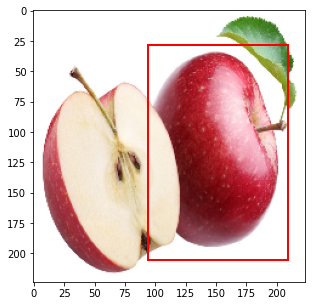

In [11]:
img, target = dataset[25]
plot_img_bbox(img, target)

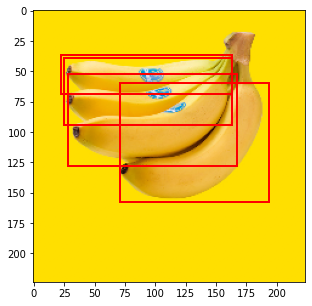

In [12]:
img, target = dataset[78]
plot_img_bbox(img, target)

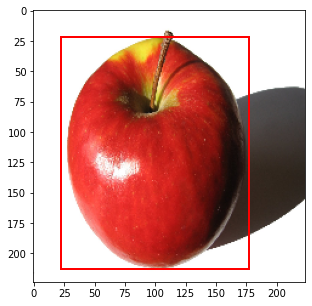

In [13]:
img, target = dataset[10]
plot_img_bbox(img, target)

**Model Development**

In [14]:
def get_model(num_classes, modelName):
    
    # Loading the pre-trained model
    if modelName == 'fastcnn':
        model = fasterrcnn_resnet50_fpn(pretrained=True)
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        return model
    
    elif modelName == 'maskcnn':
        model = maskrcnn_resnet50_fpn(pretrained=True)
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        return model

**Data Augmentation**

In [15]:
def get_transform(train=True):
    if train:
        return A.Compose([
            A.HorizontalFlip(0.5),
            ToTensorV2(p=0.1),     # ToTensorV2 converts image to PyTorch tensor without dividing by 255
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
    else:
        return A.Compose([
            ToTensorV2(p=0.1),     # ToTensorV2 converts image to PyTorch tensor without dividing by 255
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

In [16]:
#Dataset Preparation
test_split = 0.2

# Loading the training and the testing data with all tghe transformations
dataset_train = FruitImageDataset(files_dir, 480, 480, transforms=get_transform(train=True))
dataset_test = FruitImageDataset(files_dir, 480, 480, transforms=get_transform(train=False))

torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# Train test split
tsize = int(len(dataset) * test_split) # Getting the splitting index
dataset_train = torch.utils.data.Subset(dataset_train, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

# Defining dataloaders
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=8, shuffle=True,
                                              num_workers=4, collate_fn=utils.collate_fn)  # Imported form helper library
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=8, shuffle=True,
                                              num_workers=4, collate_fn=utils.collate_fn)

**Model Training**

In [17]:
#Model Training
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 4 # Can try by changing to 3 as 1 class is devoted for background
num_epochs = 9

def start_training(modelName, num_epochs, num_classes):
    model = get_model(num_classes, modelName)
    model.to(device)
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.005)
    
    # Learning rate decreases by 10 every 5 epochs
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    
    for epoch in range(num_epochs):
        train_one_epoch(model, optimizer, dataloader_train, device, epoch, print_freq=5)
        lr_scheduler.step()
        evaluate(model, dataloader_test, device=device)
    return model

**Fast-RCNN**

In [18]:
fast_rcnn = start_training('fastcnn', num_epochs, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

Epoch: [0]  [ 0/24]  eta: 0:04:00  lr: 0.000222  loss: 1.5222 (1.5222)  loss_classifier: 1.2767 (1.2767)  loss_box_reg: 0.2360 (0.2360)  loss_objectness: 0.0051 (0.0051)  loss_rpn_box_reg: 0.0042 (0.0042)  time: 10.0112  data: 1.1982  max mem: 7173
Epoch: [0]  [ 5/24]  eta: 0:00:55  lr: 0.001308  loss: 1.0673 (1.1699)  loss_classifier: 0.8388 (0.9027)  loss_box_reg: 0.2360 (0.2574)  loss_objectness: 0.0031 (0.0046)  loss_rpn_box_reg: 0.0043 (0.0052)  time: 2.9464  data: 0.2503  max mem: 7436
Epoch: [0]  [10/24]  eta: 0:00:31  lr: 0.002394  loss: 0.9403 (0.9695)  loss_classifier: 0.5727 (0.6842)  loss_box_reg: 0.2777 (0.2757)  loss_objectness: 0.0031 (0.0044)  loss_rpn_box_reg: 0.0044 (0.0052)  time: 2.2678  data: 0.1472  max mem: 7436
Epoch: [0]  [15/24]  eta: 0:00:18  lr: 0.003480  loss: 0.8017 (0.8861)  loss_classifier: 0.4952 (0.5911)  loss_box_reg: 0.2777 (0.2840)  loss_objectness: 0.0042 (0.0052)  loss_rpn_box_reg: 0.0045 (0.0058)  time: 2.0198  data: 0.1101  max mem: 7436
Epoch: 

**Decoding Predictions**

In [19]:
def apply_nms(prediction, threshold):
    # torchvision returns the indices of the boxes to keep
    keep = torchvision.ops.nms(prediction['boxes'], prediction['scores'], threshold)
    
    final_prediction = prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# Function to convert a torch tensor to a PIL Image
def tensorToPIL(img):
    return transforms.ToPILImage()(img).convert('RGB')

**Fast-RCNN model testing**

In [20]:
# pick one image from the test set
img, target = dataset_test[5]

# put the model in evaluation mode
fast_rcnn.eval()
with torch.no_grad():
    prediction = fast_rcnn([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  6
real #boxes:  1


EXPECTED OUTPUT


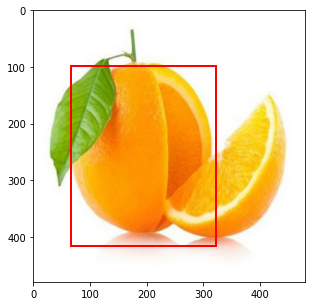

In [21]:
print('EXPECTED OUTPUT')
plot_img_bbox(tensorToPIL(img), target)

EXPECTED OUTPUT



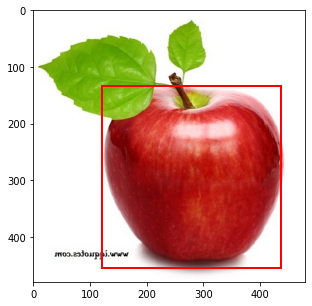

In [24]:
test_dataset = FruitImageDataset(test_dir, 480, 480, transforms= get_transform(train=True))
# pick one image from the test set
img, target = test_dataset[10]
# put the model in evaluation mode
fast_rcnn.eval()
with torch.no_grad():
    prediction = fast_rcnn([img.to(device)])[0]
    
print('EXPECTED OUTPUT\n')
plot_img_bbox(tensorToPIL(img), target)
#print('MODEL OUTPUT\n')
#nms_prediction = apply_nms(prediction, threshold=0.01)

#plot_img_bbox(tensorToPIL(img), nms_prediction)

**Model Architecture**

In [25]:
fast_rcnn

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

**Python**

gwdwdvfh